# Data Preprocessing and Model Training

The dataset is from https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data 

Inspiration for data preparation is from https://www.kaggle.com/code/abdallahabuelftouh/loan-approval-classification-logistic-svc-and-knn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import time
import joblib

In [3]:
df = pd.read_csv('./data/loan_data.csv')

So, after loading the raw data, we need to make sure that all values are numeric.

- boolean values should be mapped to 0 and 1 (--> gender)
- categories with ordinal hierarchy can be mapped between 0 and n (--> education)
- categories without ordinal hierarchy should be one-hot encoded (--> intent)

since 'person_home_ownership' 'OTHER' only occurs a few times with low interpretability, we will help our model by throwing out those entries.

In [4]:
df['person_gender'] = df['person_gender'].map({'male': 0, 'female': 1})

education_mapping = {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
df['person_education'] = df['person_education'].map(education_mapping)

df = df[df['person_home_ownership'] != 'OTHER']

home_ownership_mapping = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2}
df['person_home_ownership'] = df['person_home_ownership'].map(home_ownership_mapping)

intent_dummies = pd.get_dummies(df['loan_intent'], prefix='loan_intent')
df = pd.concat([df, intent_dummies], axis=1)
df = df.drop('loan_intent', axis=1)

df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})

numerical_columns = ['loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_columns = ['previous_loan_defaults_on_file', 'loan_status']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

X = df.drop('loan_status', axis=1)
y = df['loan_status']

/tmp/ipykernel_639804/1143381495.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_639804/1143381495.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [12]:
preprocessed_file_path = './data/loan_data_preprocessed.csv'
X.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to: {preprocessed_file_path}")

Preprocessed data saved to: ./loan_data_preprocessed.csv


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


In [ ]:
print("Training...")
start_time = time.time()

xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.1, 0.05],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'models/fortunate_loan_model_gpu.pkl')
print("Model saved under 'models/fortunate_loan_model_gpu.pkl'")

Training set size: 31418
Validation set size: 6732
Test set size: 6733
Training XGBoost Classifier with GPU support...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


<ipython-input-8-38b8ef74afcb>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-8-38b8ef74afcb>:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Training completed in 67.05 seconds.
Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 400}
Model saved as 'fortunate_loan_model_gpu.pkl'

Validation Set Results:
Validation Accuracy: 0.9385
Validation F1 Score: 0.8520
Confusion Matrix:
[[5126  112]
 [ 302 1192]]

Test Set Results:
Test Accuracy: 0.9314
Test F1 Score: 0.8343
Confusion Matrix:
[[5108  131]
 [ 331 1163]]
Null Accuracy: 0.7781


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:44:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


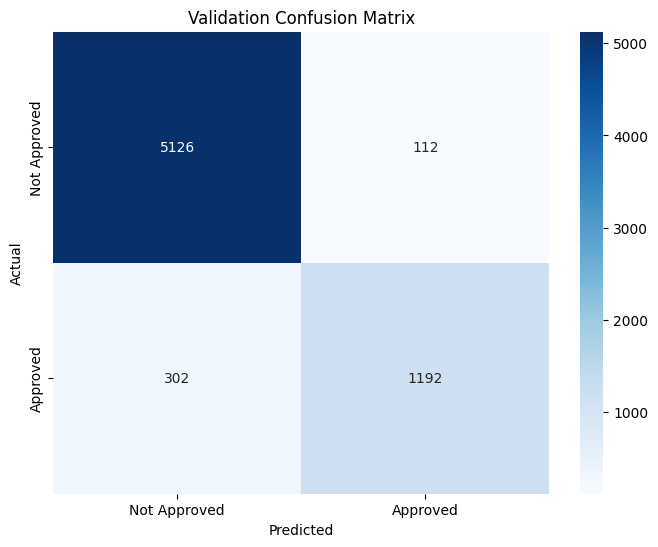

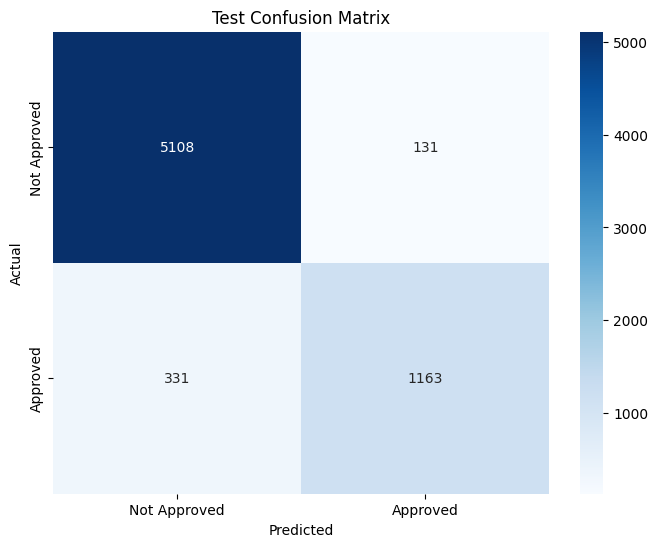

In [ ]:
print("\nValidation Set Results:")
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:")
print(val_conf_matrix)

print("\nTest Set Results:")
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)

null_accuracy = max(y_test.value_counts()) / len(y_test)
print(f"Null Accuracy: {null_accuracy:.4f}")

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(val_conf_matrix, labels=["Not Approved", "Approved"], title="Validation Confusion Matrix")
plot_confusion_matrix(test_conf_matrix, labels=["Not Approved", "Approved"], title="Test Confusion Matrix")


Age 20: 17 entries, average: 123672.58823529411
Age 21: 1281 entries, average: 52309.825136612024
Age 22: 4221 entries, average: 63159.9907604833
Age 23: 5241 entries, average: 71767.25186033199
Age 24: 5114 entries, average: 75785.79624560032
Age 25: 4496 entries, average: 77865.80516014235
Age 26: 3654 entries, average: 80889.04926108374
Age 27: 3088 entries, average: 81177.6774611399
Age 28: 2721 entries, average: 84065.09849320103
Age 29: 2449 entries, average: 86127.28991425071
Age 30: 2020 entries, average: 88300.71386138613
Age 31: 1641 entries, average: 87393.61304082876
Age 32: 1402 entries, average: 88752.91012838802
Age 33: 1240 entries, average: 87294.95161290323
Age 34: 980 entries, average: 90519.56326530612
Age 35: 847 entries, average: 88407.30342384888
Age 36: 737 entries, average: 93205.62415196744
Age 37: 666 entries, average: 91618.77177177178
Age 38: 501 entries, average: 89379.31536926147
Age 39: 389 entries, average: 90183.55269922879
Age 40: 348 entries, average

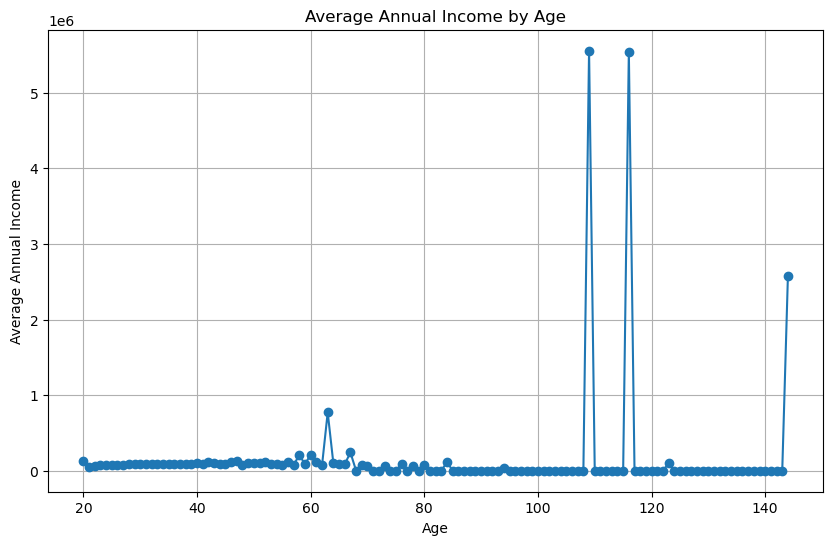

In [7]:
min_age = int(df['person_age'].min())
max_age = int(df['person_age'].max())

# Calculate both the mean income and count of entries for each age
age_income_stats = df.groupby('person_age')['person_income'].agg(['mean', 'count'])

# Reindex to include all ages in [min_age, max_age].
# Missing ages will be filled with 0.
all_ages = range(min_age, max_age + 1)
age_income_stats = age_income_stats.reindex(all_ages, fill_value=0)

# Separate out the mean and count
average_income_by_age = age_income_stats['mean']
count_by_age = age_income_stats['count']

# Print the number of entries for each age
for age in all_ages:
    print(f"Age {age}: {count_by_age[age]} entries, average: {average_income_by_age[age]}")

# Plot the average income by age
plt.figure(figsize=(10, 6))
plt.plot(average_income_by_age.index, average_income_by_age.values, marker='o', linestyle='-')
plt.xlabel('Age')
plt.ylabel('Average Annual Income')
plt.title('Average Annual Income by Age')
plt.grid(True)
plt.show()